<a href="https://colab.research.google.com/github/playanaC/SegWorm/blob/main/SegWorm_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [1]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Mar 23 11:57:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**!!! NOTE: Save the images to be processed before importing Google Drive!!!!**

In [2]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# !rm -r /content/SegWorm
!git clone https://github.com/playanaC/SegWorm.git
%cd /content/SegWorm/
!pip install -e.
!python -m pip install -U roifile

import os
import json
import torch
import tifffile
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from utils import *
from EmbedSeg_files.create_dicts import create_test_configs_dict
from EmbedSeg_files.test import begin_evaluating
from EmbedSeg_files.visualize import *
import warnings
warnings.filterwarnings('ignore')

In [4]:
#@title **Please, provide the necessary input files below:** 
base = '/content/SegWorm/' #@param {type:"string"}

tta = True
ap_val = 0.5
save_dir = base + 'inference'

checkpoint_path = '/content/SegWorm/Data/network/brightness_darker_image/' #@param {type:"string"}
data_properties_path = 'data_properties.json' #@param {type:"string"}
data_properties_path = checkpoint_path + data_properties_path
print(data_properties_path)

normalization_path = 'normalization.json' #@param {type:"string"}
normalization_path = checkpoint_path + normalization_path
print(normalization_path)

test_images = '/content/SegWorm/Data/demo_images/' #@param {type:"string"}
print(test_images)

tta = True
ap_val = 0.5
save_dir = '/content/drive/MyDrive/demo_images/' #@param {type:"string"}
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

/content/SegWorm/Data/network/brightness_darker_image/data_properties.json
/content/SegWorm/Data/network/brightness_darker_image/normalization.json
/content/SegWorm/Data/demo_images/


In [ ]:
#@title **Process test image: Convert to GRAY (To do if they are 3-channel images**)

import cv2
from tqdm import tqdm

grayRGB_images = sorted(glob(os.path.join(test_images, '*.TIF')))

path_brightness_images = test_images + 'brightness_images/'
if not os.path.exists(path_brightness_images):
    os.makedirs(path_brightness_images)

with tqdm(total=len(grayRGB_images)) as pbar:
  for i in range(len(grayRGB_images)):
    head, tail = os.path.split(grayRGB_images[i])
    name_imge = tail.split('.')[0]
    if name_imge[len(name_imge)-2:] == 'd4':
      name_img_save = path_brightness_images + name_imge + '.tif'
      if not (os.path.exists(name_img_save)):
        image = tifffile.imread(grayRGB_images[i])
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        tifffile.imsave(name_img_save, gray.astype(np.uint16))
    pbar.update(1)

test_images = path_brightness_images
print('...')
print("Evaluation images shall be read from: {}".format(test_images))

In [10]:
#@title **Load variables, network, etc.**
import zipfile

best_iou_model = checkpoint_path + 'best_iou_model'
path_save_model = best_iou_model + '/'
model_path = best_iou_model + '.zip'

with zipfile.ZipFile(model_path, 'r') as zip_ref:
    zip_ref.extractall(path_save_model)

checkpoint_model = checkpoint_path + 'best_iou_model/best_iou_model.pth'
print(checkpoint_model)

if data_properties_path:
    with open(data_properties_path) as json_file:
        data = json.load(json_file)
        one_hot, data_type, min_object_size, n_y, n_x, avg_bg = data['one_hot'], data['data_type'], \
        int(data['min_object_size']), int(data['n_y']), int(data['n_x']), float(data['avg_background_intensity'])

# if os.path.isfile(os.path.join(project_name+'-'+'demo', 'normalization.json')):
#     with open(os.path.join(project_name+'-'+'demo', 'normalization.json')) as json_file:
if normalization_path:
    with open(normalization_path) as json_file:
        data = json.load(json_file)
        norm = data['norm']

if os.path.exists(checkpoint_path):
    print("Trained model weights found at : {}".format(checkpoint_path))
else:
    print("Trained model weights were not found at the specified location!")

# Create test_configs dictionary from the above-specified parameters
cuda_available = torch.cuda.is_available()
test_configs = create_test_configs_dict(data_dir=test_images,
                                        checkpoint_path=checkpoint_model,
                                        cuda=cuda_available,
                                        tta=tta,
                                        ap_val=ap_val,
                                        min_object_size=min_object_size,
                                        save_dir=save_dir,
                                        norm=norm,
                                        data_type=data_type,
                                        one_hot=one_hot,
                                        n_y=n_y,
                                        n_x=n_x,
                                        cluster_fast=True)

# Load a glasbey-style color map
new_cmp = np.load('EmbedSeg_files/cmap_60.npy')
new_cmp = ListedColormap(new_cmp)

/content/SegWorm/Data/network/brightness_darker_image/best_iou_model/best_iou_model.pth
Trained model weights found at : /content/SegWorm/Data/network/brightness_darker_image/
`test_configs` dictionary successfully created with: 
 -- evaluation images accessed from /content/SegWorm/Data/demo_images/, 
 -- trained weights accessed from /content/SegWorm/Data/network/brightness_darker_image/best_iou_model/best_iou_model.pth, 
 -- output directory chosen as /content/drive/MyDrive/demo_images/


In [11]:
#@title **Begin Evaluating**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
begin_evaluating(test_configs, verbose=False)

2-D `test` dataloader created! Accessing data from /content/SegWorm/Data/demo_images/
Number of images in `test` directory is 2
Number of instances in `test` directory is 0
Number of center images in `test` directory is 0
*************************
Creating Branched Erfnet with [4, 1] outputs


  0%|          | 0/2 [00:00<?, ?it/s]

Created new directory /content/drive/MyDrive/demo_images/predictions/
Created new directory /content/drive/MyDrive/demo_images/ground-truth/
Created new directory /content/drive/MyDrive/demo_images/seeds/
Created new directory /content/drive/MyDrive/demo_images/predictions_masks/


100%|██████████| 2/2 [00:11<00:00,  5.94s/it]


{'fg_thresh': 0.5, 'AP_dsb_05': -0.0}

In [12]:
#@title **Load images**
prediction_file_names = sorted(glob(os.path.join(save_dir, 'predictions', '*.tif')))
prediction_mask_file_names = sorted(glob(os.path.join(save_dir, 'predictions_masks', '*.tif')))

ground_truth_file_names = sorted(glob(os.path.join(save_dir, 'ground-truth', '*.tif')))
seed_file_names = sorted(glob(os.path.join(save_dir, 'seeds', '*.tif')))
image_file_names = sorted(glob(os.path.join(test_images, '*.tif')))

print('Gray image files:', len(image_file_names))
print('Output network (seed):', len(seed_file_names))
print('Predictions files:', len(prediction_file_names))
print('Prediction mask file:', len(prediction_mask_file_names))

Gray image files: 2
Output network (seed): 2
Predictions files: 2
Prediction mask file: 2


In [14]:
#@title **Save results in folder**
folder_img_results = 'img_results' #@param {type:"string"}
folder_img_results = save_dir + folder_img_results + '/'
print(folder_img_results)

from tqdm import tqdm
from EmbedSeg_files.visualize import visualize

if not os.path.exists(folder_img_results):
    os.makedirs(folder_img_results)

with tqdm(total=len(image_file_names)) as pbar:
    pbar.update(1)
    for index in range(len(image_file_names)):
        prediction = tifffile.imread(prediction_file_names[index])
        image = tifffile.imread(image_file_names[index])
        seed = tifffile.imread(seed_file_names[index])

        # save results
        head, tail = os.path.split(image_file_names[index])
        name_imge = tail.split('.')[0]
        save_img_results = folder_img_results + name_imge + '.jpg'

        if not os.path.exists(save_img_results):
          try:
            if len(ground_truth_file_names) > 0:
              ground_truth = tifffile.imread(ground_truth_file_names[index])
              visualize(image = image, prediction = prediction, ground_truth = invert_one_hot(ground_truth), seed = seed, new_cmp = new_cmp, save_img_results=save_img_results)
            else:
              visualize(image = image, prediction = prediction, ground_truth = None, seed = seed, new_cmp = new_cmp, save_img_results=save_img_results)
          except:
              rt=-1
        pbar.update(1)

/content/drive/MyDrive/demo_images/img_results/


3it [00:00, 95.39it/s]               


In [15]:
#@title **Save Post-procesing**
folder_postprocessing_results = 'img_results_PostProcessing' #@param {type:"string"}
folder_postprocessing_results = save_dir + '/' + folder_postprocessing_results + '/'
print(folder_postprocessing_results)

if not os.path.exists(folder_postprocessing_results):
    os.makedirs(folder_postprocessing_results)

folder_postprocessing_masks = 'postprocessing_masks' #@param {type:"string"}
folder_postprocessing_masks = save_dir + '/' + folder_postprocessing_masks + '/'
print(folder_postprocessing_masks)

if not os.path.exists(folder_postprocessing_masks):
    os.makedirs(folder_postprocessing_masks)

from tqdm import tqdm
from utils import process_mask
from EmbedSeg_files.visualize import visualize_post0

with tqdm(total=len(image_file_names)) as pbar:
    pbar.update(1)
    for index in range(len(image_file_names)):
        image = tifffile.imread(image_file_names[index])
        prediction_mask = tifffile.imread(prediction_mask_file_names[index])

        # save results
        head, tail = os.path.split(image_file_names[index])
        name_imge = tail.split('.')[0]
        save_img_results = folder_postprocessing_results + name_imge + '.jpg'

        # save *.tif image
        save_img_results_tif = folder_postprocessing_masks + name_imge + '.tif'

        if not (os.path.exists(save_img_results) and os.path.exists(save_img_results_tif)):
          # post-processing prediction_mask
          try:
              results_masks = process_mask(prediction_mask)

              if not os.path.exists(save_img_results):
                  visualize_post0(image, prediction=prediction_mask, results_masks=results_masks,
                                  new_cmp=new_cmp, save_img_results=save_img_results)

              if not os.path.exists(save_img_results_tif):
                  if results_masks['worms_true'].max() != 0:
                      tifffile.imsave(save_img_results_tif, results_masks['worms_true'])
          except:
              rt = -1
        pbar.update(1)




/content/drive/MyDrive/demo_images//img_results_PostProcessing/
/content/drive/MyDrive/demo_images//postprocessing_masks/


3it [00:19,  6.65s/it]


Gray image files: /content/SegWorm/Data/demo_images//Image113.tif
Predictions files: /content/drive/MyDrive/demo_images//predictions/Image113.tif
Prediction mask file: /content/drive/MyDrive/demo_images//predictions_masks/Image113.tif


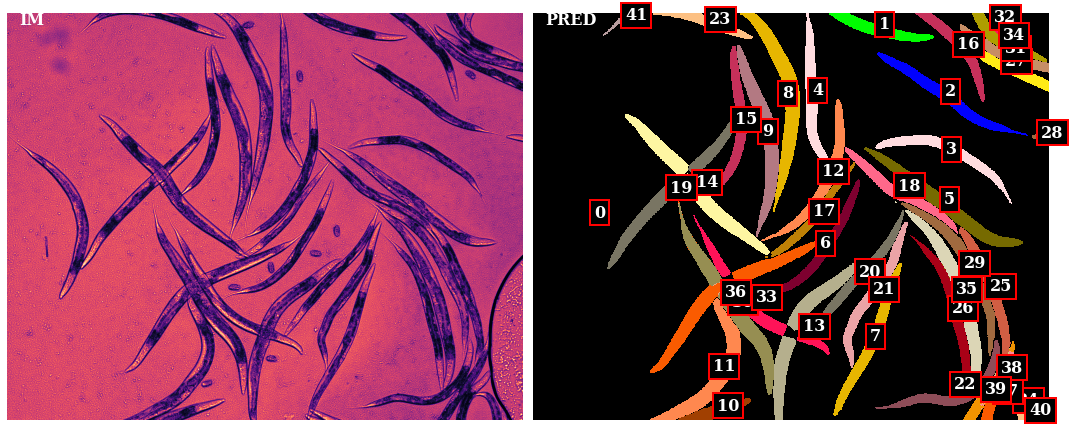

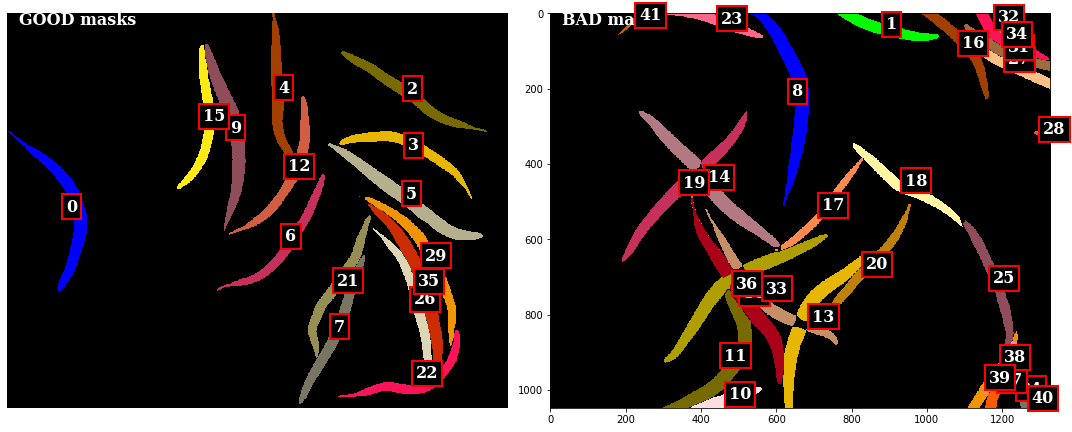

In [18]:
#@title **Show results**
# import matplotlib.image as mpimg
# from matplotlib.pyplot import imshow

# %matplotlib ipympl
%matplotlib inline
import matplotlib.pyplot as plt
# import numpy as np
# from mpl_interactions import ipyplot as iplt
# import ipywidgets as widgets
from EmbedSeg_files.visualize import visualize0, visualize2

# string
#@markdown Select a number
name_image = 'Image113' #@param {type:"string"}
# name_image = 'Image4'

prediction_file_names_i = save_dir + '/predictions/' + name_image + '.tif'
prediction_mask_file_names_i = save_dir + '/predictions_masks/' + name_image + '.tif'
image_file_names_i = test_images + '/' + name_image + '.tif'

image = tifffile.imread(image_file_names_i)
prediction_mask = tifffile.imread(prediction_mask_file_names_i)

print('Gray image files:', image_file_names_i)
print('Predictions files:', prediction_file_names_i)
print('Prediction mask file:', prediction_mask_file_names_i)

visualize0(image=image, prediction=prediction_mask, new_cmp=new_cmp)

results_masks = process_mask(prediction_mask)
visualize2(image=image, results_masks=results_masks, new_cmp=new_cmp)

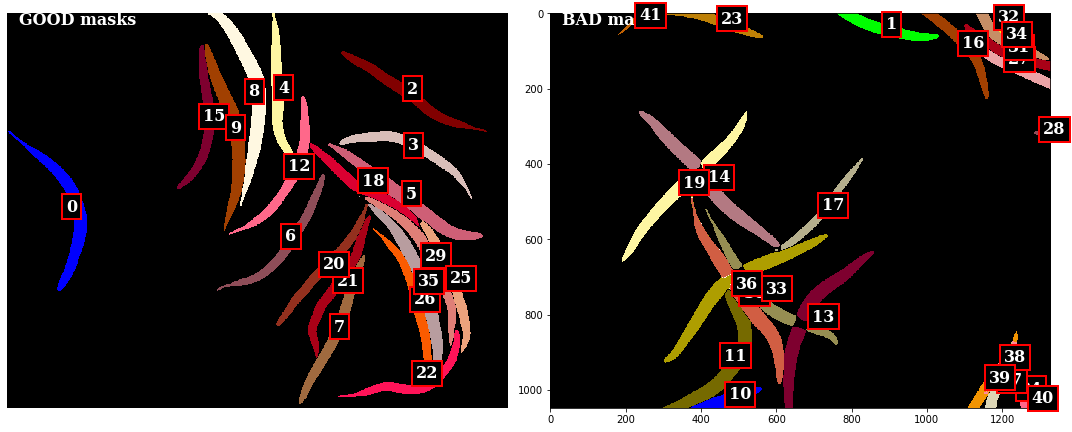

In [19]:
#@title **Change results**
#@markdown Select a number (example1: 1,2,3. Example2: ' ', exaple3: 9)
#@markdown .Example: Now we add 8,18,25,20
index_images = '0,15,9,4,12,6,21,7,22,26,35,29,5,3,2,8,18,25,20' #@param {type:"string"}

from EmbedSeg_files.visualize import visualize2
from utils import change_masks

index_images = index_images.split(',')
results_masks1 = change_masks(prediction_mask, index_images)
visualize2(image=image, results_masks=results_masks1, new_cmp=new_cmp)

In [20]:
#@title **Save results**
import os
save_img_results = folder_postprocessing_results + name_image + '.jpg'
save_img_results_tif = folder_postprocessing_masks + name_image + '.tif'
print(save_img_results)
print(save_img_results_tif)

os.remove(save_img_results)
os.remove(save_img_results_tif)
if results_masks1['worms_true'].max() != 0:
  tifffile.imsave(save_img_results_tif, results_masks1['worms_true'])

  visualize_post0(image, prediction=prediction_mask, results_masks=results_masks1,
                  new_cmp=new_cmp, save_img_results=save_img_results)

/content/drive/MyDrive/demo_images//img_results_PostProcessing/Image113.jpg
/content/drive/MyDrive/demo_images//postprocessing_masks/Image113.tif


In [28]:
#@title **Save rois in folder**
folder_rois_results = 'rois_results' #@param {type:"string"}
folder_rois_results = save_dir + '/' + folder_rois_results + '/'
print(folder_rois_results)

if not os.path.exists(folder_rois_results):
    os.makedirs(folder_rois_results)

postprocessing_masks_file_names = sorted(glob(os.path.join(save_dir, 'postprocessing_masks', '*.tif')))

import numpy as np
from matplotlib import pyplot
from skimage.measure import find_contours, label, regionprops
from roifile import ImagejRoi, roiwrite
import tifffile
from skimage import measure
from tqdm import tqdm
with tqdm(total=len(postprocessing_masks_file_names)) as pbar:
    for index in range(0, len(postprocessing_masks_file_names)):
      pbar.update(1)
      postprocessing_mask = tifffile.imread(postprocessing_masks_file_names[index])

      # save results
      head, tail = os.path.split(postprocessing_masks_file_names[index])
      name_imge = tail.split('.')[0]
      save_roi_results = folder_rois_results + name_imge + '.zip'

      list_rois = []
      for i in range(postprocessing_mask.shape[0]):
          image_bw = ((postprocessing_mask[i, :, :] > 0) * 255).astype('uint8')
          contours = measure.find_contours(image_bw, 0.8)
          
          # select bigger contour
          contours_size = []
          for j in range(len(contours)):
              contours_size.append(len(contours[j]))

          max_value = max(contours_size)
          max_index = contours_size.index(max_value)
      

          contour = contours[max_index]
          X = contour[:, 0]
          Y = contour[:, 1]
          XY = np.stack((Y, X), axis=-1)
          roi = ImagejRoi.frompoints(XY)
          list_rois.append(roi)

      if len(list_rois) != 0:
          roiwrite(save_roi_results, list_rois)

/content/drive/MyDrive/demo_images//rois_results/


100%|██████████| 2/2 [00:00<00:00,  3.25it/s]
